In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, BatchNormalization, Average, Conv2D, MaxPooling2D, Activation, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical, Sequence
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10

from sklearn.metrics import classification_report
from itertools import tee

import numpy as np
import matplotlib.pyplot as plt

print("tensorflow:", tf.__version__)
print("tf.keras:", tf.keras.__version__)
# print(tf.python.keras.preprocessing.__version__)

tensorflow: 1.14.0
tf.keras: 2.2.4-tf


In [2]:
batch_size=512

In [3]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
    tf.compat.v1.disable_eager_execution()
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

In [4]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)

def dice_loss2(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
    return 1 - numerator / denominator

In [5]:
def conv_model_Autoencoder(level = 2, input_shape=(28,28,1)):
    base_filters_count = 32
    filters_count_list = [base_filters_count * (i+1) for i in range(level)]
    
    img_input = Input(input_shape)
    
    x = Conv2D(filters=filters_count_list[0], kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters_count_list[0], kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    for i in range(level-1):
        x = Conv2D(filters=filters_count_list[i+1], kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=filters_count_list[i+1], kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D()(x)
    x1 = x
    print(x1.shape)
    
    for i in range(level, 0, -1):
        x = Conv2DTranspose(filters=filters_count_list[i-1], kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(filters=filters_count_list[i-1], kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
    x = Conv2D(filters=1, kernel_size=(3, 3), strides=(1,1), activation='sigmoid', padding='same')(x)
    
    autoencoder_model = Model(img_input, x)
    autoencoder_model.compile(optimizer="adam",
#                   loss='mean_squared_error',
                  loss=dice_loss2,
                  metrics=['accuracy'])
    return autoencoder_model

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [7]:
# X_train = X_train[:1000]
# y_train = y_train[:1000]

In [8]:
X_train = X_train / 255.
X_test = X_test / 255.

X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))

In [9]:
X_train.shape

(60000, 28, 28, 1)

In [10]:
X_test.shape

(10000, 28, 28, 1)

In [11]:
X_train[0].shape

(28, 28, 1)

In [12]:
raw_xtrain_noise = np.random.randn(X_train.shape[0],X_train.shape[1],X_train.shape[2],X_train.shape[3])
raw_xtest_noise = np.random.randn(X_test.shape[0],X_test.shape[1],X_test.shape[2],X_test.shape[3])

X_train; Noise factor: 0:


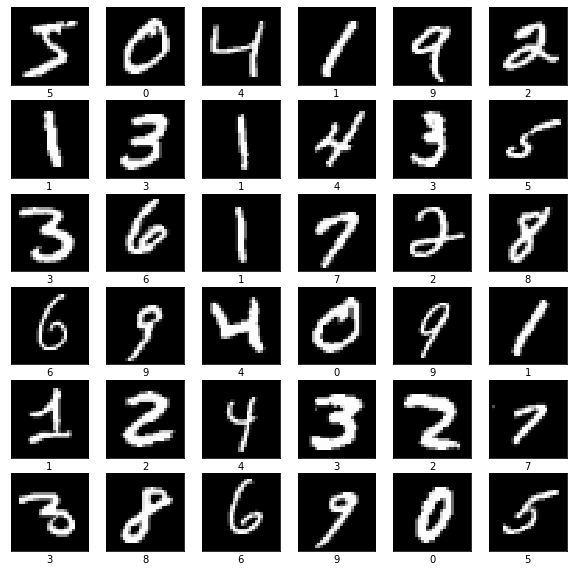

In [13]:
print("X_train; Noise factor: 0:")
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.xlabel(str(y_train[i]))
plt.show()

## Коэффициент зашумления 0.1

In [14]:
X_train_noised = X_train + raw_xtrain_noise * 0.1
X_test_noised = X_test + raw_xtest_noise * 0.1 

X_train; Noise factor: 0.1:


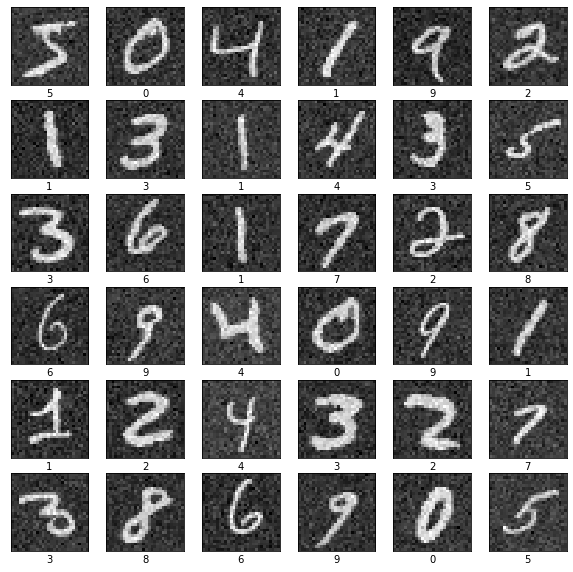

In [15]:
print("X_train; Noise factor: 0.1:")
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_noised[i].reshape(28,28), cmap='gray')
    plt.xlabel(str(y_train[i]))
plt.show()

X_test; Noise factor: 0.1:


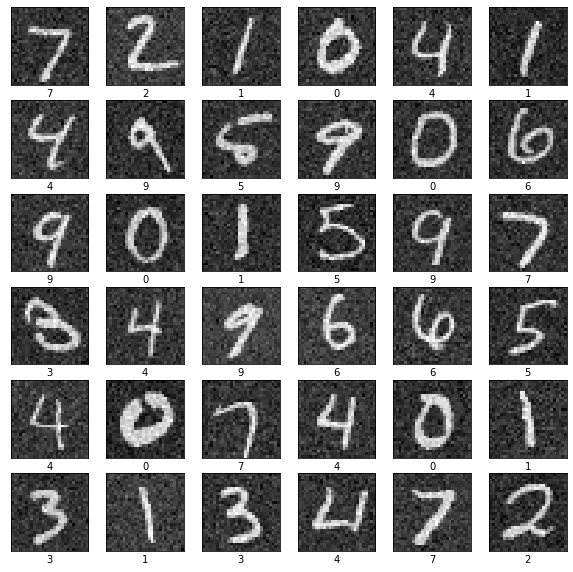

In [16]:
print("X_test; Noise factor: 0.1:")
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_noised[i].reshape(28,28), cmap='gray')
    plt.xlabel(str(y_test[i]))
plt.show()

In [17]:
K.clear_session()
autoencoder_model = conv_model_Autoencoder(level=2, input_shape=(28,28,1))

(?, 7, 7, 64)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

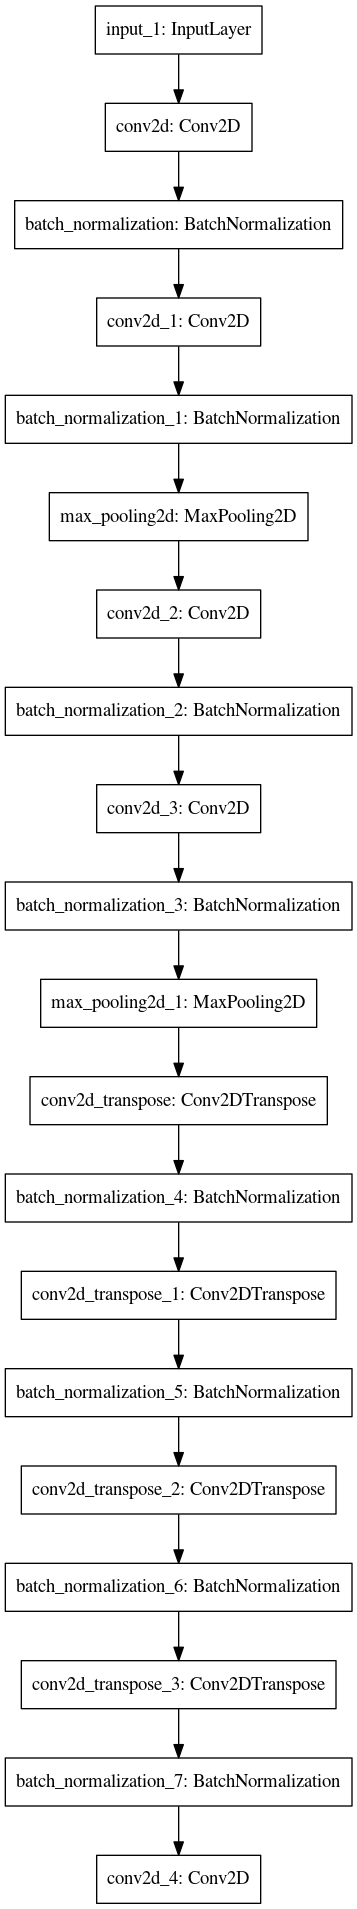

In [45]:
plot_model(autoencoder_model)

In [19]:
checkpoint = ModelCheckpoint('mnist_autoencoder_noise_0.1.hdf5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=1,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-7, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [20]:
history = autoencoder_model.fit(X_train_noised, X_train,
                                batch_size=batch_size,
                                epochs=999999999999, 
                                validation_data=(X_test_noised, X_test),
                                callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback]
                               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.2583 - acc: 0.7741
Epoch 00001: val_acc improved from -inf to 0.81347, saving model to mnist_autoencoder_noise_0.1.hdf5
60000/60000 [==============================] - 12s 192us/sample - loss: 0.2581 - acc: 0.7741 - val_loss: 0.1472 - val_acc: 0.8135
Epoch 2/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1266 - acc: 0.8152
Epoch 00002: val_acc improved from 0.81347 to 0.81429, saving model to mnist_autoencoder_noise_0.1.hdf5
60000/60000 [==============================] - 10s 164us/sample - loss: 0.1266 - acc: 0.8152 - val_loss: 0.1227 - val_acc: 0.8143
Epoch 3/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1202 - acc: 0.8154
Epoch 00003: val_acc improved from 0.81429 to 0.81435, saving model to mnist_autoencoder_noise_0.1.hdf5
60000/60000 [==============================] - 10s 162us/sample - 

Epoch 26/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1129 - acc: 0.8155
Epoch 00026: val_acc did not improve from 0.81449
60000/60000 [==============================] - 10s 164us/sample - loss: 0.1129 - acc: 0.8155 - val_loss: 0.1114 - val_acc: 0.8145
Epoch 27/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1129 - acc: 0.8155
Epoch 00027: val_acc did not improve from 0.81449
60000/60000 [==============================] - 10s 163us/sample - loss: 0.1129 - acc: 0.8155 - val_loss: 0.1114 - val_acc: 0.8145
Epoch 28/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1128 - acc: 0.8155
Epoch 00028: val_acc improved from 0.81449 to 0.81449, saving model to mnist_autoencoder_noise_0.1.hdf5
60000/60000 [==============================] - 10s 162us/sample - loss: 0.1128 - acc: 0.8155 - val_loss: 0.1114 - val_acc: 0.8145
Epoch 29/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1

59904/60000 [============================>.] - ETA: 0s - loss: 0.1127 - acc: 0.8155
Epoch 00053: val_acc did not improve from 0.81449
60000/60000 [==============================] - 10s 160us/sample - loss: 0.1127 - acc: 0.8155 - val_loss: 0.1113 - val_acc: 0.8145
Epoch 54/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1127 - acc: 0.8155
Epoch 00054: val_acc did not improve from 0.81449

Epoch 00054: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
60000/60000 [==============================] - 10s 159us/sample - loss: 0.1127 - acc: 0.8155 - val_loss: 0.1113 - val_acc: 0.8145
Epoch 55/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1127 - acc: 0.8155
Epoch 00055: val_acc did not improve from 0.81449
60000/60000 [==============================] - 10s 161us/sample - loss: 0.1127 - acc: 0.8155 - val_loss: 0.1113 - val_acc: 0.8145
Epoch 56/999999999999
59904/60000 [============================>.] - ETA: 0s - loss

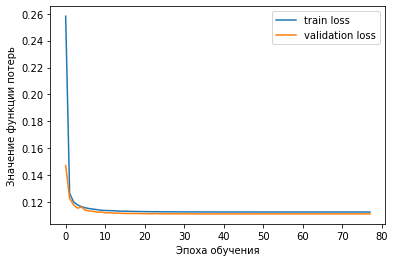

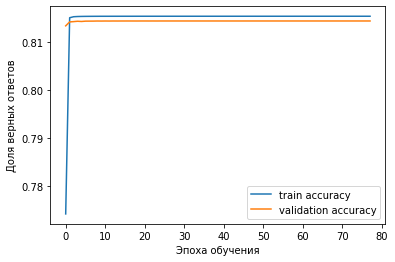

In [21]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [22]:
X_test_pred = autoencoder_model.predict(X_test_noised)

X_test_pred:


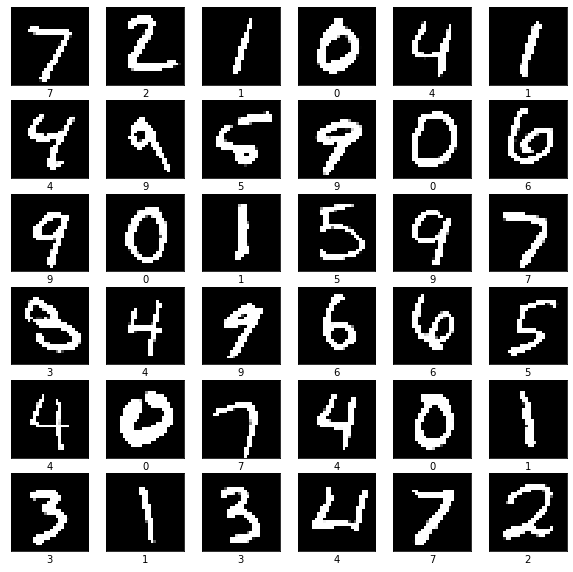

In [23]:
print("X_test_pred:")
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_pred[i].reshape(28,28), cmap='gray')
    plt.xlabel(str(y_test[i]))
plt.show()

In [24]:
dice_score, accuracy = autoencoder_model.evaluate(X_test_noised, X_test)
print("Dice:", dice_score)
print("Accuracy:", accuracy)

10000/10000 [==============================] - 1s 83us/sample - loss: 0.1114 - acc: 0.8145
Dice: 0.11137516446113586
Accuracy: 0.8144856


## Коэффициент зашумления 0.4

In [25]:
X_train_noised = X_train + raw_xtrain_noise * 0.4
X_test_noised = X_test + raw_xtest_noise * 0.4

X_train; Noise factor: 0.4:


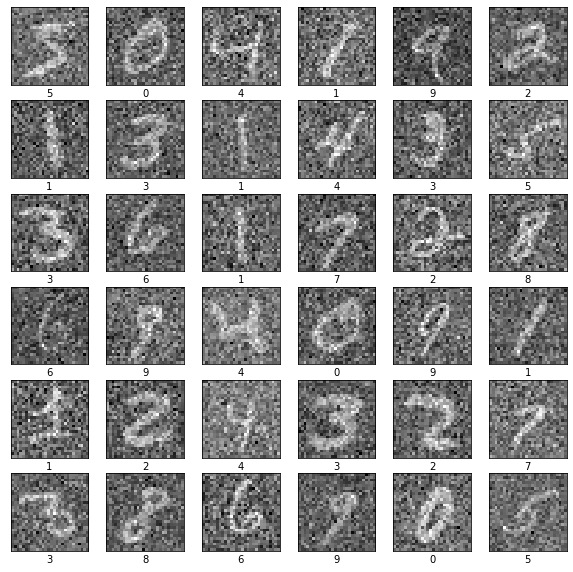

In [26]:
print("X_train; Noise factor: 0.4:")
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_noised[i].reshape(28,28), cmap='gray')
    plt.xlabel(str(y_train[i]))
plt.show()

X_test; Noise factor: 0.4:


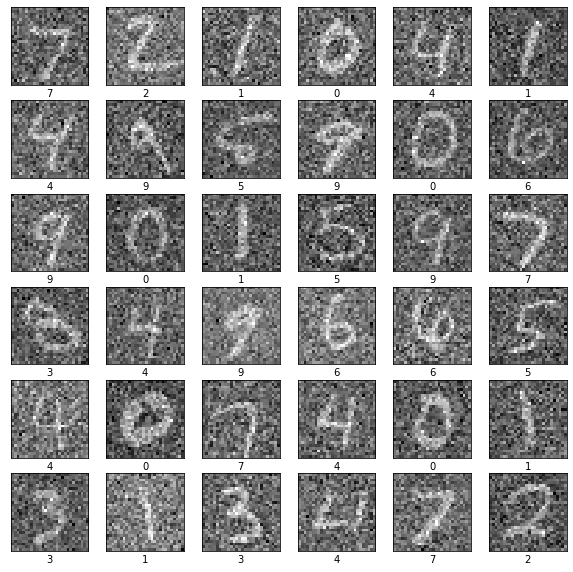

In [27]:
print("X_test; Noise factor: 0.4:")
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_noised[i].reshape(28,28), cmap='gray')
    plt.xlabel(str(y_test[i]))
plt.show()

In [28]:
del autoencoder_model
K.clear_session()
autoencoder_model = conv_model_Autoencoder(level=2, input_shape=(28,28,1))

(?, 7, 7, 64)


In [29]:
checkpoint = ModelCheckpoint('mnist_autoencoder_noise_0.4.hdf5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=1,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-7, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [30]:
history = autoencoder_model.fit(X_train_noised, X_train,
                                batch_size=batch_size,
                                epochs=999999999999, 
                                validation_data=(X_test_noised, X_test),
                                callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback]
                               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.2659 - acc: 0.7797
Epoch 00001: val_acc improved from -inf to 0.80412, saving model to mnist_autoencoder_noise_0.4.hdf5
60000/60000 [==============================] - 11s 178us/sample - loss: 0.2657 - acc: 0.7797 - val_loss: 0.1927 - val_acc: 0.8041
Epoch 2/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1548 - acc: 0.8136
Epoch 00002: val_acc improved from 0.80412 to 0.81173, saving model to mnist_autoencoder_noise_0.4.hdf5
60000/60000 [==============================] - 10s 164us/sample - loss: 0.1548 - acc: 0.8135 - val_loss: 0.1522 - val_acc: 0.8117
Epoch 3/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1478 - acc: 0.8140
Epoch 00003: val_acc improved from 0.81173 to 0.81305, saving model to mnist_autoencoder_noise_0.4.hdf5
60000/60000 [==============================] - 10s 165us/sample - 

Epoch 27/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1360 - acc: 0.8148
Epoch 00027: val_acc did not improve from 0.81363
60000/60000 [==============================] - 10s 166us/sample - loss: 0.1360 - acc: 0.8148 - val_loss: 0.1376 - val_acc: 0.8135
Epoch 28/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1360 - acc: 0.8147
Epoch 00028: val_acc did not improve from 0.81363
60000/60000 [==============================] - 10s 165us/sample - loss: 0.1360 - acc: 0.8148 - val_loss: 0.1375 - val_acc: 0.8135
Epoch 29/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1360 - acc: 0.8148
Epoch 00029: val_acc did not improve from 0.81363
60000/60000 [==============================] - 10s 165us/sample - loss: 0.1360 - acc: 0.8148 - val_loss: 0.1376 - val_acc: 0.8135
Epoch 30/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1358 - acc: 0.8148
Epoch 00030: val_acc did not improve

59904/60000 [============================>.] - ETA: 0s - loss: 0.1353 - acc: 0.8148
Epoch 00054: val_acc did not improve from 0.81363
60000/60000 [==============================] - 10s 160us/sample - loss: 0.1353 - acc: 0.8148 - val_loss: 0.1375 - val_acc: 0.8135
Epoch 55/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1353 - acc: 0.8148
Epoch 00055: val_acc did not improve from 0.81363
60000/60000 [==============================] - 10s 159us/sample - loss: 0.1353 - acc: 0.8148 - val_loss: 0.1375 - val_acc: 0.8135
Epoch 56/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.1352 - acc: 0.8148
Epoch 00056: val_acc did not improve from 0.81363

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
60000/60000 [==============================] - 10s 159us/sample - loss: 0.1352 - acc: 0.8148 - val_loss: 0.1375 - val_acc: 0.8135
Epoch 57/999999999999
59904/60000 [============================>.] - ETA: 0s - los

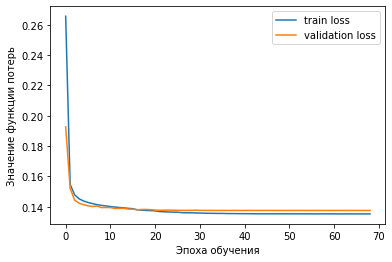

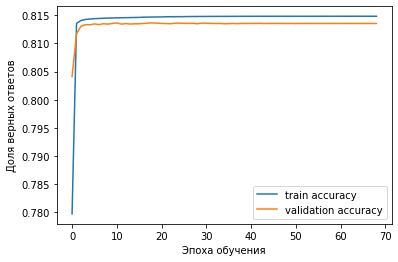

In [31]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [32]:
X_test_pred = autoencoder_model.predict(X_test_noised)

X_test_pred:


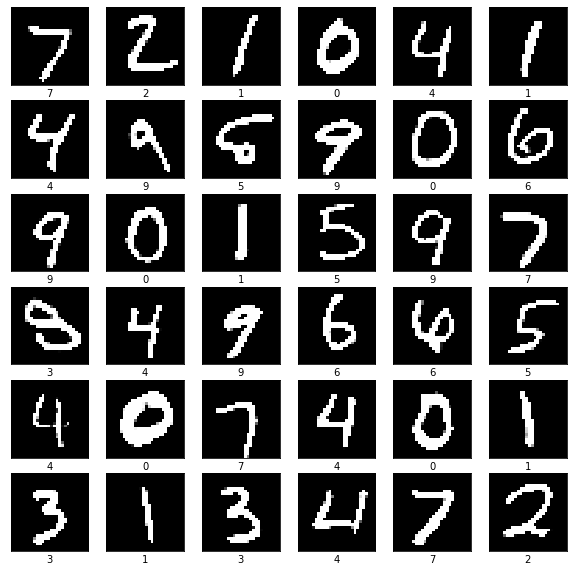

In [33]:
print("X_test_pred:")
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_pred[i].reshape(28,28), cmap='gray')
    plt.xlabel(str(y_test[i]))
plt.show()

In [34]:
dice_score, accuracy = autoencoder_model.evaluate(X_test_noised, X_test)
print("Dice:", dice_score)
print("Accuracy:", accuracy)

10000/10000 [==============================] - 1s 87us/sample - loss: 0.1382 - acc: 0.8136
Dice: 0.13818052209615708
Accuracy: 0.813631


## Коэффициент зашумления 0.9

In [35]:
X_train_noised = X_train + raw_xtrain_noise * 0.9
X_test_noised = X_test + raw_xtest_noise * 0.9

X_train; Noise factor: 0.9:


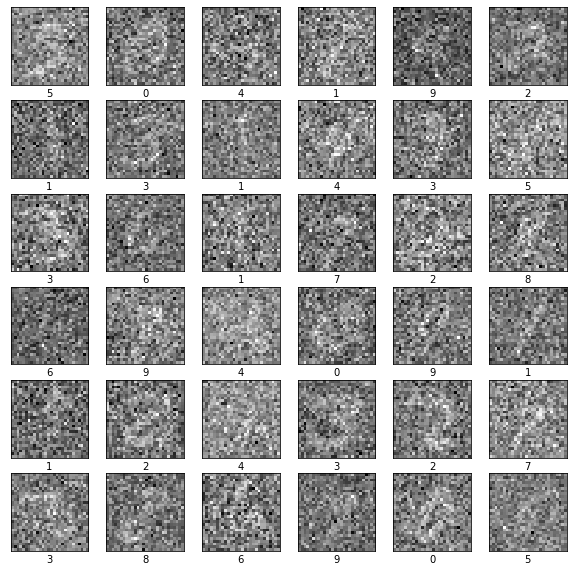

In [36]:
print("X_train; Noise factor: 0.9:")
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_noised[i].reshape(28,28), cmap='gray')
    plt.xlabel(str(y_train[i]))
plt.show()

X_test; Noise factor: 0.9:


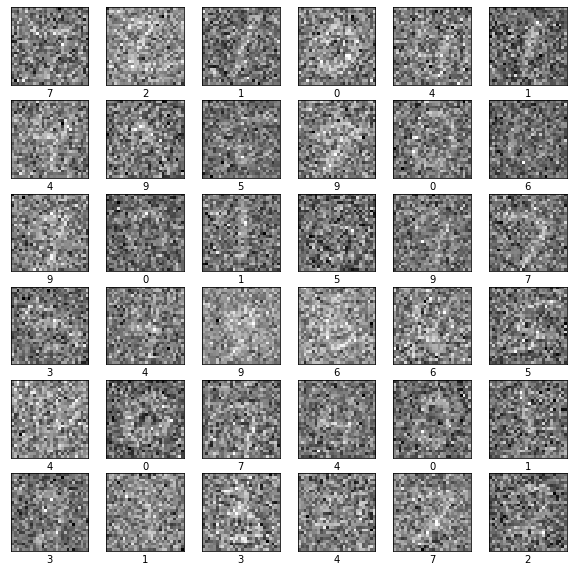

In [37]:
print("X_test; Noise factor: 0.9:")
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_noised[i].reshape(28,28), cmap='gray')
    plt.xlabel(str(y_test[i]))
plt.show()

In [38]:
del autoencoder_model
K.clear_session()
autoencoder_model = conv_model_Autoencoder(level=2, input_shape=(28,28,1))

(?, 7, 7, 64)


In [39]:
checkpoint = ModelCheckpoint('mnist_autoencoder_noise_0.9.hdf5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=1,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-7, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [40]:
history = autoencoder_model.fit(X_train_noised, X_train,
                                batch_size=batch_size,
                                epochs=999999999999, 
                                validation_data=(X_test_noised, X_test),
                                callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback]
                               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.3437 - acc: 0.7618
Epoch 00001: val_acc improved from -inf to 0.71430, saving model to mnist_autoencoder_noise_0.9.hdf5
60000/60000 [==============================] - 11s 180us/sample - loss: 0.3435 - acc: 0.7619 - val_loss: 0.3918 - val_acc: 0.7143
Epoch 2/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.2529 - acc: 0.8005
Epoch 00002: val_acc improved from 0.71430 to 0.78313, saving model to mnist_autoencoder_noise_0.9.hdf5
60000/60000 [==============================] - 10s 167us/sample - loss: 0.2529 - acc: 0.8005 - val_loss: 0.2682 - val_acc: 0.7831
Epoch 3/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.2435 - acc: 0.8022
Epoch 00003: val_acc improved from 0.78313 to 0.79593, saving model to mnist_autoencoder_noise_0.9.hdf5
60000/60000 [==============================] - 10s 166us/sample - 

59904/60000 [============================>.] - ETA: 0s - loss: 0.2155 - acc: 0.8061
Epoch 00027: val_acc did not improve from 0.80582

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
60000/60000 [==============================] - 10s 160us/sample - loss: 0.2155 - acc: 0.8061 - val_loss: 0.2246 - val_acc: 0.8044
Epoch 28/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.2130 - acc: 0.8065
Epoch 00028: val_acc did not improve from 0.80582
60000/60000 [==============================] - 10s 160us/sample - loss: 0.2130 - acc: 0.8065 - val_loss: 0.2234 - val_acc: 0.8041
Epoch 29/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.2120 - acc: 0.8066
Epoch 00029: val_acc did not improve from 0.80582
60000/60000 [==============================] - 10s 159us/sample - loss: 0.2120 - acc: 0.8067 - val_loss: 0.2235 - val_acc: 0.8042
Epoch 30/999999999999
59904/60000 [============================>.] - ETA: 0s - loss

59904/60000 [============================>.] - ETA: 0s - loss: 0.2046 - acc: 0.8076
Epoch 00054: val_acc did not improve from 0.80582
60000/60000 [==============================] - 10s 160us/sample - loss: 0.2046 - acc: 0.8076 - val_loss: 0.2239 - val_acc: 0.8042
Epoch 55/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.2045 - acc: 0.8077
Epoch 00055: val_acc did not improve from 0.80582
60000/60000 [==============================] - 10s 161us/sample - loss: 0.2045 - acc: 0.8077 - val_loss: 0.2238 - val_acc: 0.8041
Epoch 56/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.2045 - acc: 0.8077
Epoch 00056: val_acc did not improve from 0.80582
60000/60000 [==============================] - 10s 161us/sample - loss: 0.2045 - acc: 0.8077 - val_loss: 0.2238 - val_acc: 0.8040
Epoch 57/999999999999
59904/60000 [============================>.] - ETA: 0s - loss: 0.2045 - acc: 0.8077
Epoch 00057: val_acc did not improve from 0.80582

Epoch 0

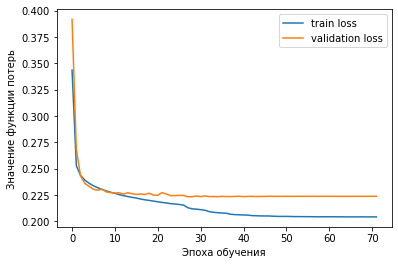

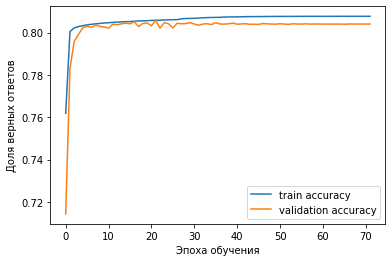

In [41]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [42]:
X_test_pred = autoencoder_model.predict(X_test_noised)

X_test_pred:


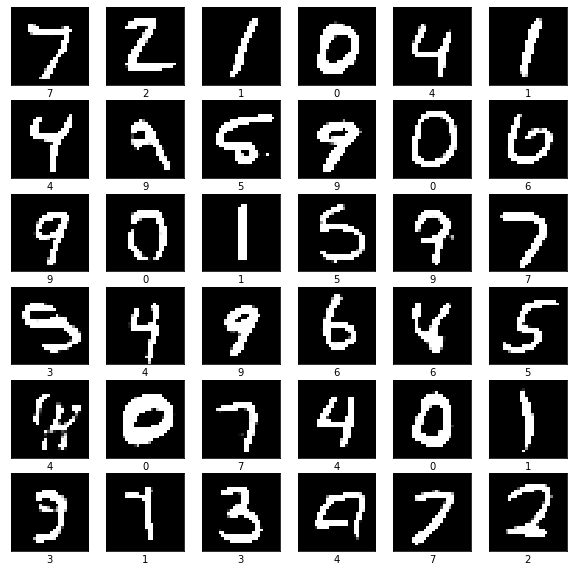

In [43]:
print("X_test_pred:")
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_pred[i].reshape(28,28), cmap='gray')
    plt.xlabel(str(y_test[i]))
plt.show()

In [44]:
dice_score, accuracy = autoencoder_model.evaluate(X_test_noised, X_test)
print("Dice:", dice_score)
print("Accuracy:", accuracy)

10000/10000 [==============================] - 1s 79us/sample - loss: 0.2274 - acc: 0.8058
Dice: 0.22735679790973665
Accuracy: 0.80581695


## При изменении коэффициента шума, при прочих равных, получаем в итоге заметное ухудшение значение DSC, при незначительном ухудшении метрики accuracy. Визуально выходной результат при шумах 0.1 и 0.4 сравнимый, а вот некоторые выходные изображения при шуме 0.9 невозможно различить даже человеку.